<a href="https://colab.research.google.com/github/rashmi05pathak/Dental_Panoramic_X-ray_segmentation/blob/main/EE20S051_EE20S049.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import numpy as np
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted
script_dir=os.path.abspath(os.path.dirname(sys.argv[0]))
default_path=script_dir+'/Original_Masks/'

In [ ]:
def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

In [ ]:
def pre_images(resize_shape,path,include_zip):
    if include_zip==True:
        ZipFile(path+"/DentalPanoramicXrays.zip").extractall(path) 
        path=path+'/Images/'
    dirs=natsorted(os.listdir(path))
    sizes=np.zeros([len(dirs),2])
    images=img=Image.open(path+dirs[0])
    sizes[0,:]=images.size
    images=(images.resize((resize_shape),Image.ANTIALIAS))
    images=convert_one_channel(np.asarray(images))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        sizes[i,:]=img.size
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],1))
    return images,sizes

In [ ]:
def pre_masks(resize_shape=(512,512),path=default_path):
    ZipFile(path+"/Orig_Masks.zip").extractall(path+'/Masks/') 
    path=path+'/Masks/'
    dirs=natsorted(os.listdir(path))
    masks=img=Image.open(path+dirs[0])
    masks=(masks.resize((resize_shape),Image.ANTIALIAS))
    masks=convert_one_channel(np.asarray(masks))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        masks=np.concatenate((masks,img))
    masks=np.reshape(masks,(len(dirs),resize_shape[0],resize_shape[1],1))
    return masks

In [ ]:
default_path=script_dir+'/Custom_Masks/'
#CustomMasks 512x512
def pre_splitted_masks(path=default_path):
    ZipFile(path+"/splitted_masks.zip").extractall(path+'/Masks/') 
    path=path+'/Masks/'
    dirs=natsorted(os.listdir(path))
    masks=img=Image.open(path+dirs[0])
    masks=convert_one_channel(np.asarray(masks))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        img=convert_one_channel(np.asarray(img))
        masks=np.concatenate((masks,img))
    masks=np.reshape(masks,(len(dirs),512,512,1))
    return masks

In [ ]:
#### MODEL ###
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,Conv2DTranspose,Dropout
from tensorflow.keras.models import Model

In [ ]:
def UNET (input_shape=(512,512,1),last_activation='sigmoid'):
    inputs=Input(shape=input_shape)
    
    conv1 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    d1=Dropout(0.1)(conv1)
    conv2 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d1)
    b=BatchNormalization()(conv2)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(b)
    conv3 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    d2=Dropout(0.2)(conv3)
    conv4 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d2)
    b1=BatchNormalization()(conv4)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(b1)
    conv5 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    d3=Dropout(0.3)(conv5)
    conv6 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d3)
    b2=BatchNormalization()(conv6)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(b2)
    conv7 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    d4=Dropout(0.4)(conv7)
    conv8 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d4)
    b3=BatchNormalization()(conv8)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(b3)
    conv9 = Conv2D(512,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    d5=Dropout(0.5)(conv9)
    conv10 = Conv2D(512,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d5)
    b4=BatchNormalization()(conv10)
    
    
    conv11 = Conv2DTranspose(512,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b4)
    x= concatenate([conv11,conv8])
    conv12 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    d6=Dropout(0.4)(conv12)
    conv13 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d6)
    b5=BatchNormalization()(conv13)
    
    
    conv14 = Conv2DTranspose(256,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b5)
    x1=concatenate([conv14,conv6])
    conv15 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x1)
    d7=Dropout(0.3)(conv15)
    conv16 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d7)
    b6=BatchNormalization()(conv16)
    
    conv17 = Conv2DTranspose(128,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b6)
    x2=concatenate([conv17,conv4])
    conv18 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x2)
    d8=Dropout(0.2)(conv18)
    conv19 = Conv2D(64,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d8)
    b7=BatchNormalization()(conv19)
    
    conv20 = Conv2DTranspose(64,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b7)
    x3=concatenate([conv20,conv2])
    conv21 = Conv2D(32,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x3)
    d9=Dropout(0.1)(conv21)
    conv22 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d9)
    
    outputs = Conv2D(1,(1,1), activation = last_activation, padding = 'same', kernel_initializer = 'he_normal')(conv22)
    model2 = Model( inputs = inputs, outputs = outputs)
    
    return model2

In [ ]:
path = "/content/drive/MyDrive/ED6001_TermProject/DentalPanoramicXrays"
#pre_images(resize_shape,path,include_zip)
X,X_sizes=pre_images((512,512),path,True)

In [ ]:
Y=pre_splitted_masks(path) 

In [ ]:
X=np.float32(X/255)
Y=np.float32(Y/255)

In [ ]:
x_train=X[:105,:,:,:]
y_train=Y[:105,:,:,:]
x_test=X[105:,:,:,:]
y_test=Y[105:,:,:,:]

In [ ]:
import random
import matplotlib.pyplot as plt
random_number=random.randint(0,104)
print(random_number)

90


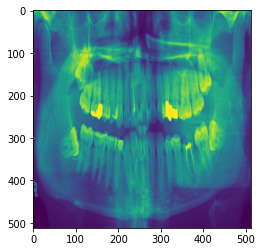

In [ ]:
#Checking data X  and Y matching
plt.imshow(x_train[random_number,:,:,0])

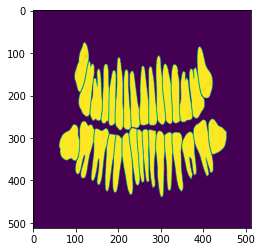

In [ ]:
#Checking data X  and Y matching
plt.imshow(y_train[random_number,:,:,0])

In [ ]:
#from model import *
model=UNET(input_shape=(512,512,1),last_activation='sigmoid')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Your choice batch and epoch 
history = model.fit(x_train,y_train,validation_split=0.1,batch_size=8,epochs=150,verbose=1)

Epoch 1/150
12/12 [==============================] - 86s 5s/step - loss: 0.4594 - accuracy: 0.7499 - val_loss: 0.4753 - val_accuracy: 0.7376
Epoch 2/150
12/12 [==============================] - 30s 2s/step - loss: 0.2855 - accuracy: 0.8291 - val_loss: 2.8981 - val_accuracy: 0.7374
Epoch 3/150
12/12 [==============================] - 30s 2s/step - loss: 0.2100 - accuracy: 0.8582 - val_loss: 1.9993 - val_accuracy: 0.7385
Epoch 4/150
12/12 [==============================] - 30s 2s/step - loss: 0.1752 - accuracy: 0.8728 - val_loss: 2.3636 - val_accuracy: 0.7380
Epoch 5/150
12/12 [==============================] - 30s 2s/step - loss: 0.1577 - accuracy: 0.8789 - val_loss: 1.6196 - val_accuracy: 0.7393
Epoch 6/150
12/12 [==============================] - 30s 3s/step - loss: 0.1479 - accuracy: 0.8820 - val_loss: 0.6377 - val_accuracy: 0.7406
Epoch 7/150
12/12 [==============================] - 30s 2s/step - loss: 0.1385 - accuracy: 0.8860 - val_loss: 0.8159 - val_accuracy: 0.7403
Epoch 8/150
1

In [ ]:
#***Uncomment to save the model
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
    #json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
#print("Saved model to disk")
 

In [ ]:
from keras.models import model_from_json
json_file = open('/content/drive/MyDrive/ED6001_TermProject/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/ED6001_TermProject/model.h5")
print("Loaded model from disk")

Loaded model from disk


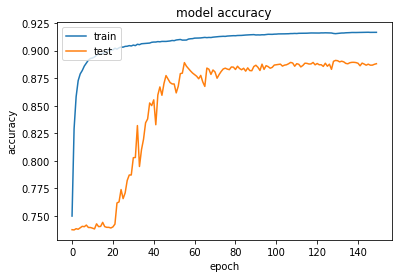

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

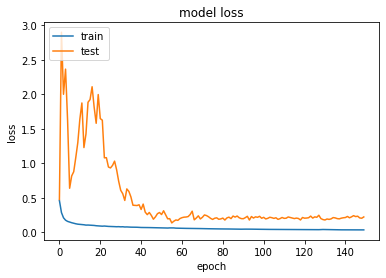

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predict_img=loaded_model.predict(x_test)

In [ ]:
#plt.imshow(y_test[1,:,:,0])

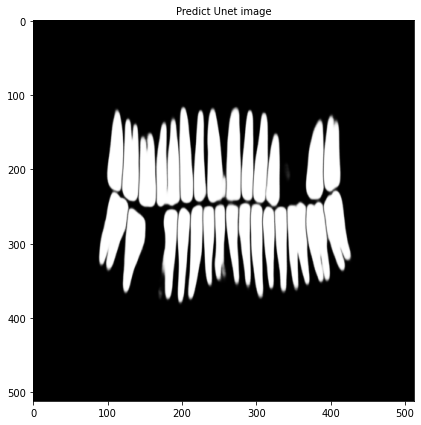

In [ ]:
UNet_out1=predict_img[1,:,:,0]
UNet_out2=predict_img[3,:,:,0]
UNet_out3=predict_img[5,:,:,0]
plt.figure(figsize = (7,7))
plt.title("Predict Unet image",fontsize = 10)
plt.imshow(UNet_out1,'gray')

Fuzzy C means

In [ ]:
!pip install scikit-fuzzy

     |████████████████████████████████| 993 kB 6.9 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=f4b2570eaa45904f73d0fd9dd66f93e562ca8adee075276d3b1fd9c691371981
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


In [ ]:
from skfuzzy.cluster import cmeans 
def fuzzy_cmeans_seg(img, n_clusters):

    #img = cv2.blur(img, (15, 15))
    EPS = 0.01    
    K1 = np.ones((2, 2), np.uint8)
    M = 2.0
    flat = img.reshape((1, -1))
    centres, u, a1, a2, a3, a4, a5 = cmeans(flat, n_clusters, M, EPS, 50)
    """
    tumor_index = np.argmax(centres, axis=0)
    defuz = np.argmax(u, axis=0)
    mask = np.full(defuz.shape[0], 0, dtype=np.uint8)
    mask[defuz == tumor_index] = 1
    mask = mask.reshape(img.shape)
    
    
    plt.imshow(mask,cmap = 'gray')
    plt.figure()
    """

    u = u*255/(np.max(u)-np.min(u))
    mask_me = np.zeros((n_clusters,u.shape[1]),dtype=np.uint8)
    
    if n_clusters ==3:
      label = ['Original','Segmented']
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
      ax[0].imshow(img, cmap='gray')
      ax[0].set_title(label[0])
      ax[0].axis('off')

      for i in range(1,n_clusters-1):
        mask_me[i] = u[i]
        mask_me[i,mask_me[i] == centres[i]] = 255
        ax[i].imshow(mask_me[i].reshape(img.shape), cmap='gray')
        ax[i].set_title(label[i])
        ax[i].axis('off')
      plt.show()

    else:
      for i in range(n_clusters-1):
        mask_me[i] = u[i]
        mask_me[i,mask_me[i] == centres[i]] = 255
      label = ['Original','Segmented']
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))

      ax[0].imshow(img, cmap='gray')
      ax[0].set_title(label[0])
      ax[0].axis('off')

      ax[1].imshow(mask_me[3].reshape(img.shape), cmap='gray')
      ax[1].set_title(label[1])
      ax[1].axis('off')
      plt.show()

    return mask_me[1].reshape(img.shape)

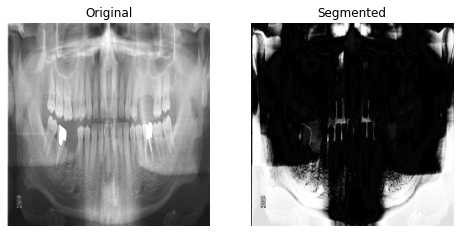

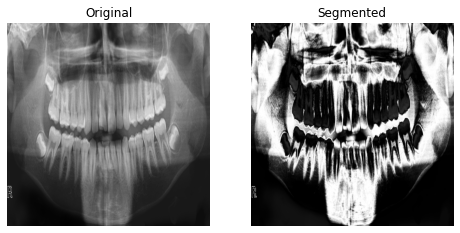

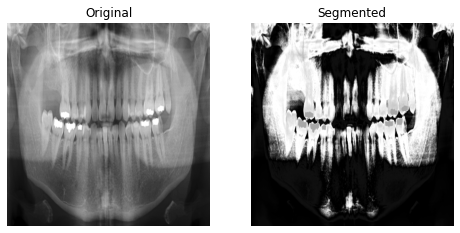

In [ ]:
CM_out1 = fuzzy_cmeans_seg(x_test[1,:,:,0],3)
CM_out2 = fuzzy_cmeans_seg(x_test[3,:,:,0],3)
CM_out3 = fuzzy_cmeans_seg(x_test[5,:,:,0],3)

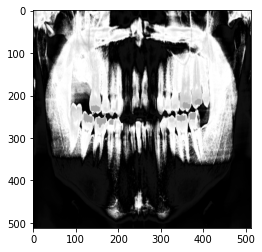

In [ ]:
plt.imshow(CM_out3,'gray')

GMM

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
def gmm(image,n_components):
    img2 = image.reshape((-1,1))
    #covariance choices, full, tied, diag, spherical
    if n_components==3:
            gmm_model_tied = GMM(n_components,random_state=3, covariance_type='full').fit(img2)  #tied works better than full
            gmm_labels_tied = gmm_model_tied.predict(img2)

            #Put numbers back to original shape so we can reconstruct segmented image
            #original_shape = image.shape

            segmented_tied = gmm_labels_tied.reshape(image.shape[0], image.shape[1])

            tooth_segmented = np.copy(image)
            labels=np.unique(segmented_tied)
            tooth_segmented[segmented_tied!=labels[2]] = 0
            
            # csf_gmm = np.copy(image)
            # csf_gmm[segmented_tied!=labels[0]] = 50
            # lvl4=np.copy(image)
            # lvl4[segmented_tied!=labels[1]] = 0
            display = [image,tooth_segmented]
            label = ['original image','tooth_segmented']

            fig = plt.figure(figsize=(20,20))

            for i in range(len(display)):
              fig.add_subplot(5,5, i+1)
              plt.imshow(display[i], cmap = 'gray')
              plt.title(label[i])

            plt.show()
    
      
    return tooth_segmented


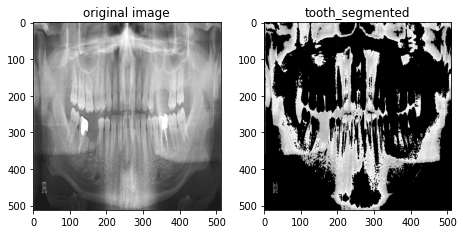

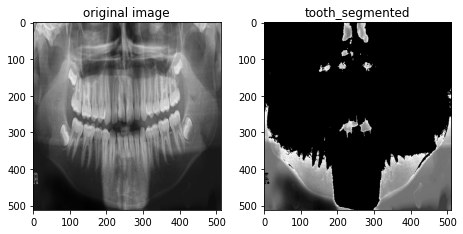

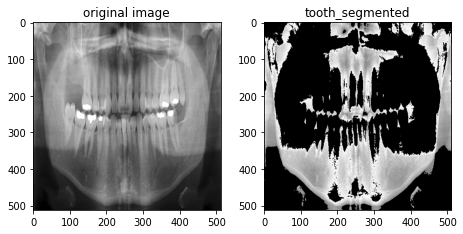

In [ ]:
GMM_out1 = gmm(x_test[1,:,:,0],3)
GMM_out2 = gmm(x_test[3,:,:,0],3)
GMM_out3 = gmm(x_test[5,:,:,0],3)

Watershed

In [ ]:
import cv2
from scipy.ndimage import label
from skimage.filters import threshold_multiotsu

def segment_on_dt(a, img):
    border = cv2.dilate(img, None, iterations=5)
    border = border - cv2.erode(border, None)
    a = cv2.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    dt = cv2.distanceTransform(img, 2, 3)
    dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
    _, dt = cv2.threshold(dt, 0.1*dt.max(), 255, cv2.THRESH_BINARY)
    #print(dt)
    lbl, ncc = label(dt)
    lbl = lbl * (255 / (ncc + 1))
    # Completing the markers now. 
    lbl[border == 255] = 255
    image = cv2.cvtColor(a, cv2.COLOR_GRAY2RGB)
    lbl = lbl.astype(np.int32)
    marker32 = np.int32(lbl)
    markers=cv2.watershed(image, marker32)

    markers[markers == -1] = 0
    markers = markers.astype(np.uint8)
    return 255 - markers

def watershed(img):
  
  fig = plt.figure(figsize = (10, 8))
  thresholds = threshold_multiotsu(img,3)  
  regions = np.digitize(img, bins=thresholds)
  display = [img,regions==2,regions==1]
  label = ['extracted_brain','White matter','Gray matter']
  WM=display[1]
  GM=display[2]
  thresholds = threshold_multiotsu(img,4)
  regions = np.digitize(img, bins=thresholds)
  display = [img,regions==1]
  label = ['extracted_brain','CSF',]
  CSF=display[1]

  
  
  thresh=np.uint8(WM)
  _, img_bin = cv2.threshold(thresh, 0, 255,  cv2.THRESH_OTSU)
  img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, np.ones((3, 3), dtype=int))

  result = segment_on_dt(img, img_bin)
  resultCopy=cv2.normalize(src=result, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  contours, hierarchy= cv2.findContours(resultCopy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  mask = np.zeros_like(result) # Create mask where white is what we want, black otherwise
  cv2.drawContours(mask, contours, -1, 255, -1) # Draw filled contour in mask
  tooth_segmented = cv2.bitwise_and(mask, img, mask = None) 
  
 
  
  
  thresh=np.uint8(GM)
  _, img_bin = cv2.threshold(thresh, 0, 255,  cv2.THRESH_OTSU)
  img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, np.ones((3, 3), dtype=int))

  result = segment_on_dt(img, img_bin)
 

  resultCopy=cv2.normalize(src=result, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  contours, hierarchy= cv2.findContours(resultCopy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  mask = np.zeros_like(result) # Create mask where white is what we want, black otherwise
  cv2.drawContours(mask, contours, -1, 255, -1) # Draw filled contour in mask
  gum = cv2.bitwise_and(mask, img, mask = None) 
 
  

  thresh=np.uint8(CSF)
  _, img_bin = cv2.threshold(thresh, 0, 255,  cv2.THRESH_OTSU)
  img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, np.ones((3, 3), dtype=int))

  result = segment_on_dt(img, img_bin)
  resultCopy=cv2.normalize(src=result, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  contours, hierarchy= cv2.findContours(resultCopy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  mask = np.zeros_like(result) # Create mask where white is what we want, black otherwise
  cv2.drawContours(mask, contours, -1, 255, -1) # Draw filled contour in mask
  csf = cv2.bitwise_and(mask, img, mask = None) 
  display = [img, tooth_segmented]
  label = ['original  image','tooth_segmented']
  fig = plt.figure(figsize=(20,20))
  for i in range(len(display)):
    fig.add_subplot(5,5, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])
  plt.show()
  return tooth_segmented
 
  
  

<Figure size 720x576 with 0 Axes>

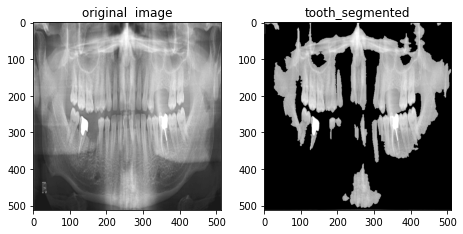

<Figure size 720x576 with 0 Axes>

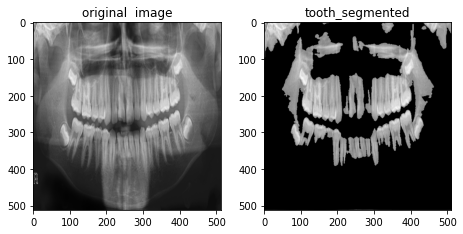

<Figure size 720x576 with 0 Axes>

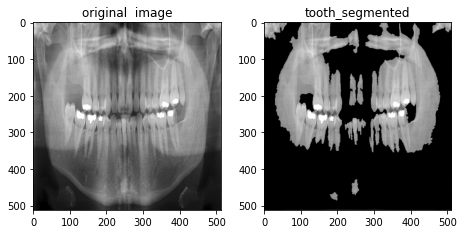

In [ ]:
img1 = x_test[1,:,:,0]
img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)
img2 = x_test[3,:,:,0]
img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)
img3 = x_test[5,:,:,0]
img3 = cv2.normalize(img3, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)
WTRSHD_out1 = watershed(img1)
WTRSHD_out2 = watershed(img2)
WTRSHD_out3 = watershed(img3)

Canny Edge detection

(Text(0.5, 1.0, 'Edge Image'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

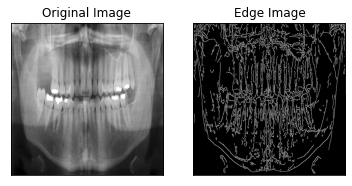

In [ ]:
#********Canny Edge detection*****************#####
import numpy as np
import cv2
from matplotlib import pyplot as plt
img1 = x_test[1,:,:,0]
img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)
img2 = x_test[3,:,:,0]
img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)
img3 = x_test[5,:,:,0]
img3 = cv2.normalize(img3, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)

canny_out1 = cv2.Canny(img1,40,80)
canny_out2 = cv2.Canny(img2,40,80)
canny_out3 = cv2.Canny(img3,40,80)
plt.subplot(121),plt.imshow(img3,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(canny_out3,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

kmeans clustering

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1149: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1149: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1149: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


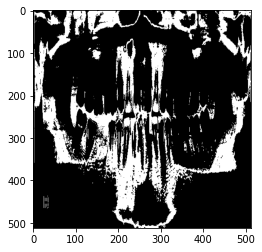

In [ ]:
from sklearn.cluster import KMeans
img1 = x_test[1,:,:,0]
img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)
img2 = x_test[3,:,:,0]
img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)
img3 = x_test[5,:,:,0]
img3 = cv2.normalize(img3, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)

kmeans1 = KMeans(n_clusters=5, init=np.array([[0],[70],[90],[110],[130]])).fit(img1.reshape(-1, 1))
init_l1 = kmeans1.predict(img1.reshape(-1, 1))
init_l1 = init_l1.reshape(img1.shape)
KM_out1 = init_l1 == 2
plt.imshow(KM_out1,'gray')

kmeans2 = KMeans(n_clusters=5, init=np.array([[0],[70],[90],[110],[130]])).fit(img2.reshape(-1, 1))
init_2 = kmeans2.predict(img2.reshape(-1, 1))
init_2 = init_2.reshape(img2.shape)
KM_out2 = init_2 == 2
#plt.imshow(KM_out2,'gray')

kmeans3 = KMeans(n_clusters=5, init=np.array([[0],[70],[90],[110],[130]])).fit(img3.reshape(-1, 1))
init_3 = kmeans3.predict(img3.reshape(-1, 1))
init_3 = init_3.reshape(img3.shape)
KM_out3 = init_3 == 2
#plt.imshow(KM_out3,'gray')

Otsu Thresholding

In [ ]:
# ***************Otsu's Thresholding******************
img1 = x_test[1,:,:,0]
img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)
img2 = x_test[3,:,:,0]
img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)
img3 = x_test[5,:,:,0]
img3 = cv2.normalize(img3, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)

ret1,OTSU_out1 = cv2.threshold(img1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,OTSU_out2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,OTSU_out3 = cv2.threshold(img3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

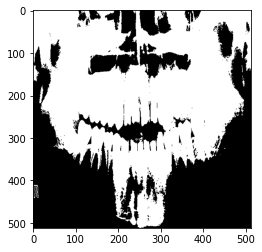

In [ ]:
plt.imshow(OTSU_out2,'gray')

Evaluation Metrics

In [ ]:
from sklearn.metrics import f1_score
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

def accuracy (result, reference):
    # accuracy=(TP+TN)/(TP+FN+FP+TN)
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    tp=  np.count_nonzero(result & reference) 
    tn = np.count_nonzero(~result & ~reference)
    fp = np.count_nonzero(result & ~reference)
    fn = np.count_nonzero(~result & reference) 
    try:
        accuracy=(tp+tn)/(tp+tn+fp+fn)
    except ZeroDivisionError:
        accuracy = 0.0
    
    return accuracy

def sensitivity (result, reference):
    # accuracy=(TP+TN)/(TP+FN+FP+TN)
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    tp=  np.count_nonzero(result & reference) 
    tn = np.count_nonzero(~result & ~reference)
    fp = np.count_nonzero(result & ~reference)
    fn = np.count_nonzero(~result & reference) 
    try:
        sensitivity=(tp/(tp+fn+1))
    except ZeroDivisionError:
        sensitivity = 0.0
    
    return sensitivity

def specificity (result, reference):
    # accuracy=(TP+TN)/(TP+FN+FP+TN)
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    tp=  np.count_nonzero(result & reference) 
    tn = np.count_nonzero(~result & ~reference)
    fp = np.count_nonzero(result & ~reference)
    fn = np.count_nonzero(~result & reference) 
    try:
        specificity=(tn/(tn+fp+1))
    except ZeroDivisionError:
        specificity = 0.0
    
    return specificity


def jc(result, reference):
    
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    
    intersection = np.count_nonzero(result & reference)
    union = np.count_nonzero(result | reference)
    
    jc = float(intersection) / float(union) #tp/tp+fn+fp
    
    return jc

def F1_score(result, reference):
  #2*TP/(TP+0.5(FP+FN))
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    tp=  np.count_nonzero(result & reference) 
    tn = np.count_nonzero(~result & ~reference)
    fp = np.count_nonzero(result & ~reference)
    fn = np.count_nonzero(~result & reference) 
    try:
        f1score= tp/(tp+0.5*(fp+fn+1))
    except ZeroDivisionError:
        f1score = 0.0
    
    return f1score


In [ ]:
orginal_mask=y_test[1,:,:,0]
orginal_mask = cv2.normalize(orginal_mask, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)

In [ ]:
F1_score(orginal_mask,UNet_out)

0.9127416357624951

In [ ]:
import pandas as pd
OTSU_out = OTSU_out1
KM_out = KM_out1
CM_out = CM_out1
WTRSHD_out = WTRSHD_out1
GMM_out = GMM_out1
canny_out = canny_out1
UNet_out = UNet_out1
UNet_out = cv2.normalize(UNet_out, None, 0, 255, cv2.NORM_MINMAX,cv2.CV_8U)
print("Matric Evaluation:")
data = {
  "OTSU": [dice(orginal_mask,OTSU_out),accuracy(orginal_mask,OTSU_out),sensitivity(orginal_mask,OTSU_out),specificity(orginal_mask,OTSU_out),jc(orginal_mask,OTSU_out),F1_score(orginal_mask,OTSU_out)],
  "K-MEANS":[dice(orginal_mask,KM_out),accuracy(orginal_mask,KM_out),sensitivity(orginal_mask,KM_out),specificity(orginal_mask,KM_out),jc(orginal_mask,KM_out),F1_score(orginal_mask,KM_out)],
  "Fuzzy C-MEANS": [dice(orginal_mask,CM_out),accuracy(orginal_mask,CM_out),sensitivity(orginal_mask,CM_out),specificity(orginal_mask,CM_out),jc(orginal_mask,CM_out),F1_score(orginal_mask,CM_out)],
  "WATERSHED":[dice(orginal_mask,WTRSHD_out),accuracy(orginal_mask,WTRSHD_out),sensitivity(orginal_mask,WTRSHD_out),specificity(orginal_mask,WTRSHD_out),jc(orginal_mask,WTRSHD_out),F1_score(orginal_mask,WTRSHD_out)],
  "GMM": [dice(orginal_mask,GMM_out),accuracy(orginal_mask,GMM_out),sensitivity(orginal_mask,GMM_out),specificity(orginal_mask,GMM_out),jc(orginal_mask,GMM_out),F1_score(orginal_mask,GMM_out)],
  "Canny": [dice(orginal_mask,canny_out),accuracy(orginal_mask,canny_out),sensitivity(orginal_mask,canny_out),specificity(orginal_mask,canny_out),jc(orginal_mask,canny_out),F1_score(orginal_mask,canny_out)],
  "UNet": [dice(orginal_mask,UNet_out),accuracy(orginal_mask,UNet_out),sensitivity(orginal_mask,UNet_out),specificity(orginal_mask,UNet_out),jc(orginal_mask,UNet_out),F1_score(orginal_mask,UNet_out)]


}
df = pd.DataFrame(data, index = ["DICE", "ACCURACY","SENSITIVITY","SPECIFICITY","JC","F1_Score"])
pd.set_option('display.max_columns', None)
print(df)

Matric Evaluation:
                 OTSU   K-MEANS  Fuzzy C-MEANS  WATERSHED       GMM     Canny  \
DICE         0.485346  0.193223       0.329743   0.494625  0.235662  0.249755   
ACCURACY     0.545353  0.631813       0.300869   0.693508  0.568325  0.725922   
SENSITIVITY  0.325888  0.191038       0.210365   0.393779  0.196192  0.326454   
SPECIFICITY  0.967258  0.764056       0.706262   0.877897  0.759335  0.790806   
JC           0.320434  0.106943       0.197421   0.328573  0.133570  0.142697   
F1_Score     0.485344  0.193221       0.329742   0.494622  0.235660  0.249752   

                 UNet  
DICE         0.912742  
ACCURACY     0.958622  
SENSITIVITY  0.870428  
SPECIFICITY  0.987795  
JC           0.839489  
F1_Score     0.912734  


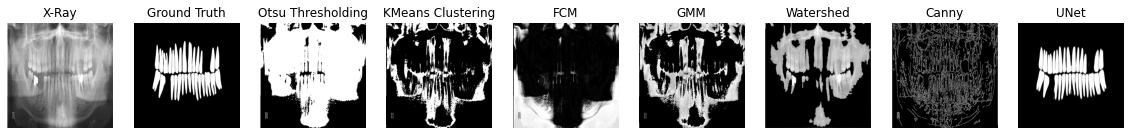

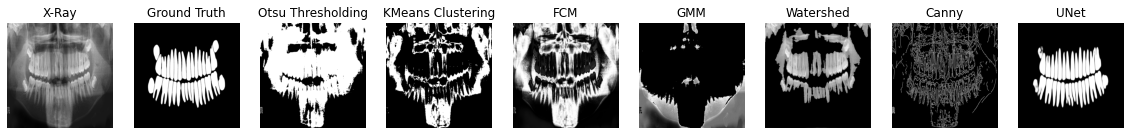

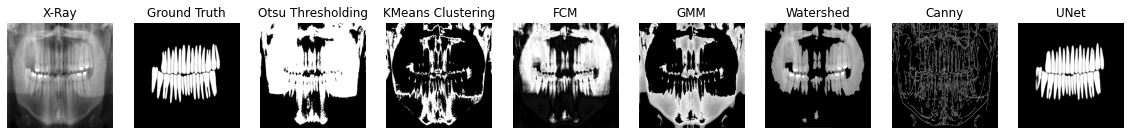

In [ ]:
label_m = ['X-Ray','Ground Truth','Otsu Thresholding','KMeans Clustering','FCM','GMM','Watershed','Canny','UNet']
IMG1 = x_test[1,:,:,0]
IMG2 = x_test[3,:,:,0]
IMG3 = x_test[5,:,:,0]
orginal_mask1 = y_test[1,:,:,0]
orginal_mask2 = y_test[3,:,:,0]
orginal_mask3 = y_test[5,:,:,0]
display_image1 = [IMG1,orginal_mask1,OTSU_out1,KM_out1,CM_out1,GMM_out1,WTRSHD_out1,canny_out1,UNet_out1]
display_image2 = [IMG2,orginal_mask2,OTSU_out2,KM_out2,CM_out2,GMM_out2,WTRSHD_out2,canny_out2,UNet_out2]
display_image3 = [IMG3,orginal_mask3,OTSU_out3,KM_out3,CM_out3,GMM_out3,WTRSHD_out3,canny_out3,UNet_out3]
fig,ax = plt.subplots(nrows=1,ncols=9,figsize =(20,20))
for i in range(len(display_image1)):
  ax[i].imshow(display_image1[i],cmap='gray')
  ax[i].set_title(label_m[i])
  ax[i].axis("off")

plt.show()

fig,ax = plt.subplots(nrows=1,ncols=9,figsize =(20,20))
for i in range(len(display_image2)):
  ax[i].imshow(display_image2[i],cmap='gray')
  ax[i].set_title(label_m[i])
  ax[i].axis("off")

plt.show()

fig,ax = plt.subplots(nrows=1,ncols=9,figsize =(20,20))

for i in range(len(display_image3)):
  ax[i].imshow(display_image3[i],cmap='gray')
  ax[i].set_title(label_m[i])
  ax[i].axis("off")

plt.show()